In [98]:
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [99]:
reportpath = 'C:/Users/liubob/Desktop/ReportingBAProject-master/Report.xlsx'
df_f = pd.read_csv('C:/Users/liubob/Desktop/ReportingBAProject-master/data/fees.csv')
df_p = pd.read_csv('C:/Users/liubob/Desktop/ReportingBAProject-master/data/policies.csv')
df_ph = pd.read_csv('C:/Users/liubob/Desktop/ReportingBAProject-master/data\policyholders.csv')
df_r = pd.read_csv('C:/Users/liubob/Desktop/ReportingBAProject-master/data/revisions.csv')

In [100]:
# Joining Policy with Revisions to get Policy Numbers
# Dropping open and pending revisions as they are not reportable

df_combine = pd.merge(df_p, df_r, how='inner', on ='policyId')
df_combine = df_combine[df_combine.revisionState != 'Open and Pending']

In [101]:
# Calculating Change in Premiums between Create Dates for each Policy Number, 
# Setting the first Change in Premium for each policy as the Written Premium

df_combine.sort_values(by=['policyNumber', 'createDate'], ascending=True, inplace=True)
df_combine.set_index(['policyNumber', 'createDate'], inplace=True)
df_combine['CIP'] = df_combine.groupby('policyNumber')['writtenPremium'].diff()
df_combine['CIP'].fillna(df_combine['writtenPremium'], inplace=True)
df_combine = df_combine.reset_index()

In [102]:
# Keeping only Policy Fees

df_f = df_f[df_f.policyTypeItemName == 'Policy Fee']

In [103]:
# Merging policy fees to the Combined data

df_combine = pd.merge(df_combine, df_f, how='outer', on ='revisionId')


In [104]:
# Removing Policy Fee for Cancellations

df_combine['writtenFee'] = np.where(pd.to_datetime(df_combine['cancelDate'])<=pd.to_datetime(df_combine['effectiveDate']),df_combine['writtenFee']*-1, df_combine['writtenFee'])

In [105]:
# Getting the previous policy status 

df_combine.sort_values(by=['policyNumber', 'createDate'], ascending=True, inplace=True)
df_combine.set_index(['policyNumber', 'createDate'], inplace=True)
df_combine['PS'] = df_combine.groupby('policyNumber')['policyStatus'].shift()
df_combine = df_combine.reset_index()

In [106]:
# Derive the transaction type

def type(df):
    if df['policyStatus'] == 'Active' and pd.isnull(df['PS']):
        return 'New'
    if df['policyStatus'] == 'Canceled' or df['policyStatus'] == 'Cancellation Pending':
        return 'Canceled'
    if df['policyStatus'] == 'Active' and df['writtenFee'] == 0:
        return 'Endorsement'
    else:
        return 'Reinstated'

df_combine['TransactionType'] = df_combine.apply (lambda df: type(df),axis=1)

In [107]:
# Combining policy holders
# Merging policy holder names with data

df_ph=df_ph.groupby(['revisionId'])['policyholderName'].apply(lambda x: ', '.join(x)).reset_index()
df_combine = pd.merge(df_combine, df_ph, how='outer', on ='revisionId')

In [108]:
# Getting the final data output
# Formatting columns

df_op = df_combine[['policyNumber', 'policyholderName', 'TransactionType', 'effectiveDate', 'CIP', 'writtenFee']]
df_op.rename(columns={"policyNumber": "Policy Number", "policyholderName": "Named Insured", "effectiveDate": "Effective Date", "TransactionType": "Transaction Type", "writtenFee": "Policy Fees", "CIP": "Change in Premium"}, inplace = True)
df_op['Effective Date'] = pd.to_datetime(df_op['Effective Date'])
df_op['Change in Premium'] = df_op['Change in Premium'].astype(float)

C:\Users\liubob\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
C:\Users\liubob\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\liubob\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

In [109]:
df_op

,Policy Number,Named Insured,Transaction Type,Effective Date,Change in Premium,Policy Fees
0,2014-5313,Catherine Hill,New,2018-03-09,7652.00,25.0
1,2014-5313,Catherine Hill,Reinstated,2018-03-09,-2254.00,25.0
2,2014-5313,Catherine Hill,Canceled,2018-03-09,-5398.00,-25.0
3,2014-5313,Catherine Hill,Reinstated,2018-03-09,5488.00,25.0
4,2014-5479,Lori Andrews,Canceled,2018-04-01,0.00,-25.0
5,2014-5548,Patrick Nelson,New,2018-06-25,19225.00,25.0
6,2014-5658,Austin Rodriguez,New,2018-04-13,1313.00,25.0
7,2014-5658,Austin Rodriguez,Reinstated,2018-04-13,1080.46,25.0
8,2015-6717,Jonathan Adams,New,2018-03-06,1554.00,25.0
9,2015-7152,Scott Henderson,New,2018-06-01,9398.00,25.0


In [110]:
# Creating the excel report
# Formatting the report

wb = openpyxl.Workbook()
ws = wb.worksheets[0]
ws['A1'] = 'Insurio Inc'
ws['A2'] = 'YTD Premium Report'



from openpyxl.utils.dataframe import dataframe_to_rows
rows = dataframe_to_rows(df_op, index = False)

for r_idx, row in enumerate(rows, 5):
    for c_idx, value in enumerate(row, 1):
         ws.cell(row=r_idx, column=c_idx, value=value)


from openpyxl.styles import PatternFill, Border, Side, Alignment, Protection, Font, NamedStyle

header = NamedStyle(name="header")
bd = Side(style='thin', color="000000")
header.border = Border(left=bd, top=bd, right=bd, bottom=bd)
header.font = Font(bold=True, underline = 'single')
header.fill = PatternFill(start_color='00e103',
                   end_color='00e103', fill_type = "solid")
header.alignment = Alignment(horizontal='center')

wb.add_named_style(header)


ws['A5'].style = 'header'
ws['B5'].style = 'header'
ws['C5'].style = 'header'
ws['D5'].style = 'header'
ws['E5'].style = 'header'
ws['F5'].style = 'header'

ws.auto_filter.ref = "A5:F5"
ws.freeze_panes = 'A6'

ws.column_dimensions['A'].width = 35
ws.column_dimensions['B'].width = 35
ws.column_dimensions['C'].width = 35
ws.column_dimensions['D'].width = 35
ws.column_dimensions['E'].width = 35
ws.column_dimensions['F'].width = 35


for cell in ws['D']:
    cell.number_format = 'm/d/yyyy'

for cell in ws['E']:
    cell.number_format = '$#,##0.00' 

for cell in ws['F']:
    cell.number_format = '#,##0;(#,##0);-'

wb.save(reportpath)

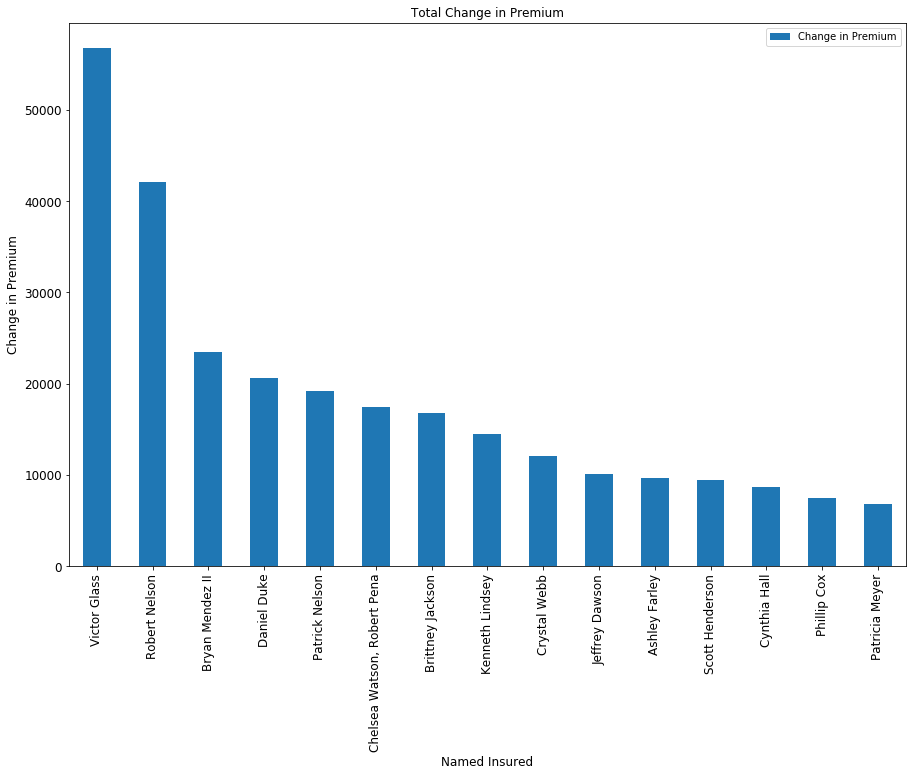

In [120]:
# Creating graphs - Total Change in Premium by Insured


CIP_Sum =df_op.groupby('Named Insured')['Change in Premium'].sum().sort_values(ascending=False)[:15].to_frame()
ax = CIP_Sum.plot(kind='bar', title ="Total Change in Premium",figsize=(15,10),legend=False, fontsize=12)
ax.set_xlabel("Named Insured",fontsize=12)
ax.set_ylabel("Change in Premium",fontsize=12) 
plt.show()

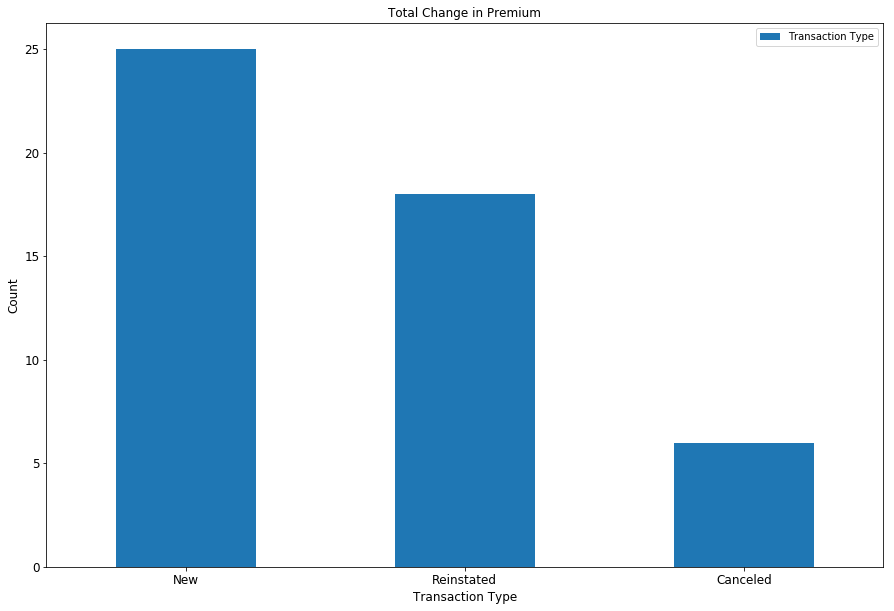

In [121]:
# Creating graphs - Count by Transaction Type

TransactionCount =df_op.groupby('Transaction Type')['Transaction Type'].count().sort_values(ascending=False)[:15].to_frame()
ax = TransactionCount.plot(kind='bar', title ="Count by Transaction Type",figsize=(15,10),legend=False, fontsize=12, rot=0)
ax.set_xlabel("Transaction Type",fontsize=12)
ax.set_ylabel("Count",fontsize=12) 
plt.show()